In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
import pickle
import csv
np.random.seed(42)
%matplotlib inline

# Importing my already scaled data

In [59]:
X_train_sc = pd.read_csv('../data/X_train_sc.csv')
X_test_sc = pd.read_csv('../data/X_test_sc.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')
df = pd.read_csv('../data/clean_data.csv')

# Instantiaing  and fitting my model

In [3]:
lasso = LassoCV(n_alphas = 500)
lasso.fit(X_train_sc, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=500, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

# Scoring my model on train and test data

In [4]:
lasso.score(X_train_sc, y_train)

0.9427428011140983

In [5]:
lasso.score(X_test_sc, y_test)

0.931286112621823

# Calculating RMSE for train and test data

In [6]:
y_hat_train = lasso.predict(X_train_sc)
y_hat_test = lasso.predict(X_test_sc)

In [7]:
mean_squared_error(y_train, y_hat_train) ** .5

19035.56821221147

In [8]:
mean_squared_error(y_test, y_hat_test) ** .5

20552.134717385536

In [9]:
lasso.intercept_

181070.10980604656

In [10]:
with open('../assets/columns.pkl', 'rb') as f:
    columns = pickle.load(f)

# Creating a dataframe of coefficients to see their weight

In [101]:
coef = pd.DataFrame(lasso.coef_, index = columns, columns=['weight'])
coef.sort_values(by='weight', ascending=False).head(10)

,weight
Gr Liv Area,23471.178068
Total Bsmt SF,13996.739001
Overall Qual_9,8971.231104
Overall Qual_10,6991.115534
Year Built,6561.344276
Overall Qual_8,5428.658509
Neighborhood_StoneBr,4468.106529
Bldg Type_1Fam,4439.597261
Exter Qual_Ex,4313.314150
Lot Area,4143.704118


In [102]:
coef = pd.DataFrame(lasso.coef_, index = columns, columns=['weight'])
coef.sort_values(by='weight', ascending=True).head(10)

,weight
Roof Matl_ClyTile,-14491.812195
Misc Feature_Elev,-12566.326535
Bsmt Unf SF,-4979.101825
Overall Cond_3,-3235.280215
Exter Qual_TA,-2136.436807
Garage Type_2Types,-1640.383625
Fireplaces_0,-1632.541313
Functional_Maj1,-1613.546731
Half Bath_2,-1522.229704
Bedroom AbvGr_5,-1224.164656


# Creating plots based on my model

In [37]:
betas = pd.DataFrame(lasso.coef_, index = columns)

In [38]:
betas.columns = ['weight']

In [39]:
betas['abs_w'] = betas.weight.abs()

In [40]:
betas.head()

,weight,abs_w
PID,-0.000000,0.000000
MS SubClass,-44.045222,44.045222
Lot Frontage,168.411709,168.411709
Lot Area,4143.704118,4143.704118
Year Built,6561.344276,6561.344276


In [41]:
weights = betas.sort_values('abs_w', ascending=False)['weight'].head(20)

In [42]:
labels = weights.index

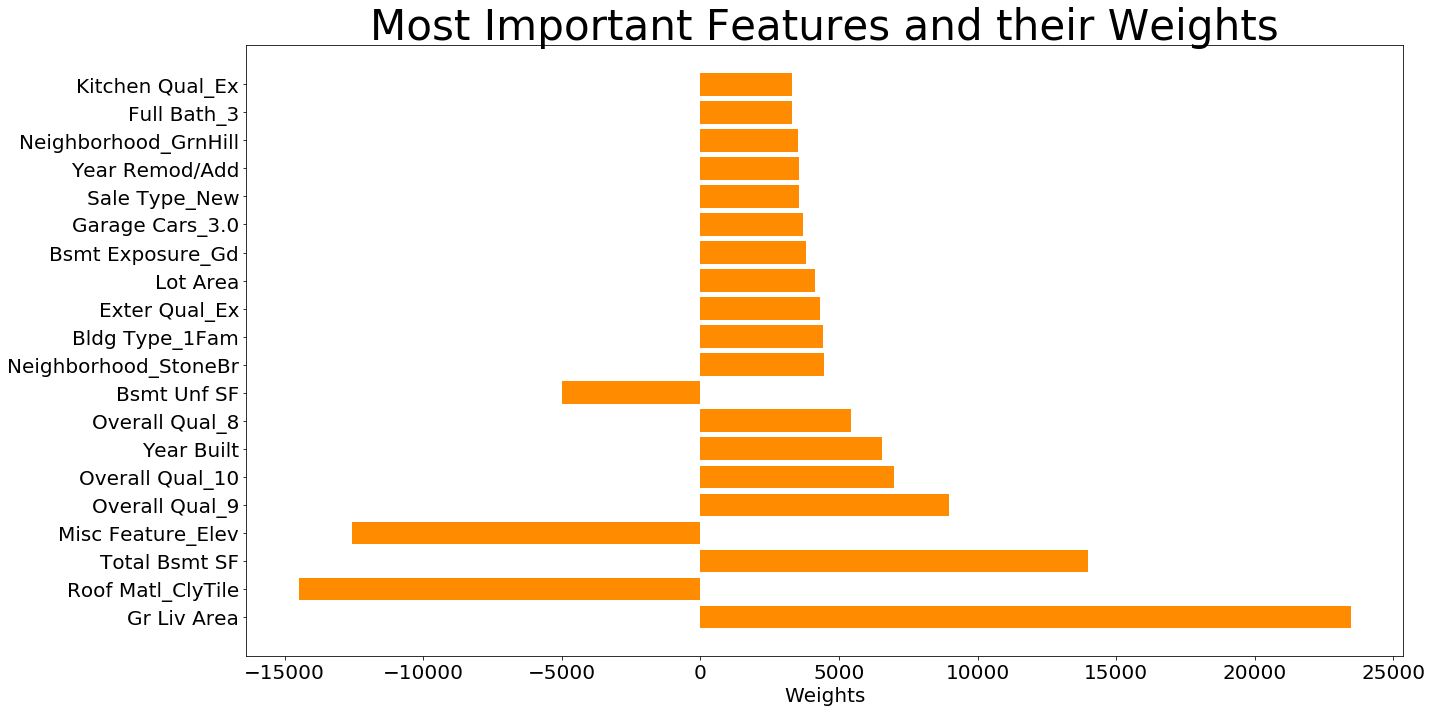

In [58]:
plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = 'darkorange')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=20)
plt.title(f'Most Important Features and their Weights', fontsize=42)
plt.tight_layout()

Text(0,0.5,'Sale Price')

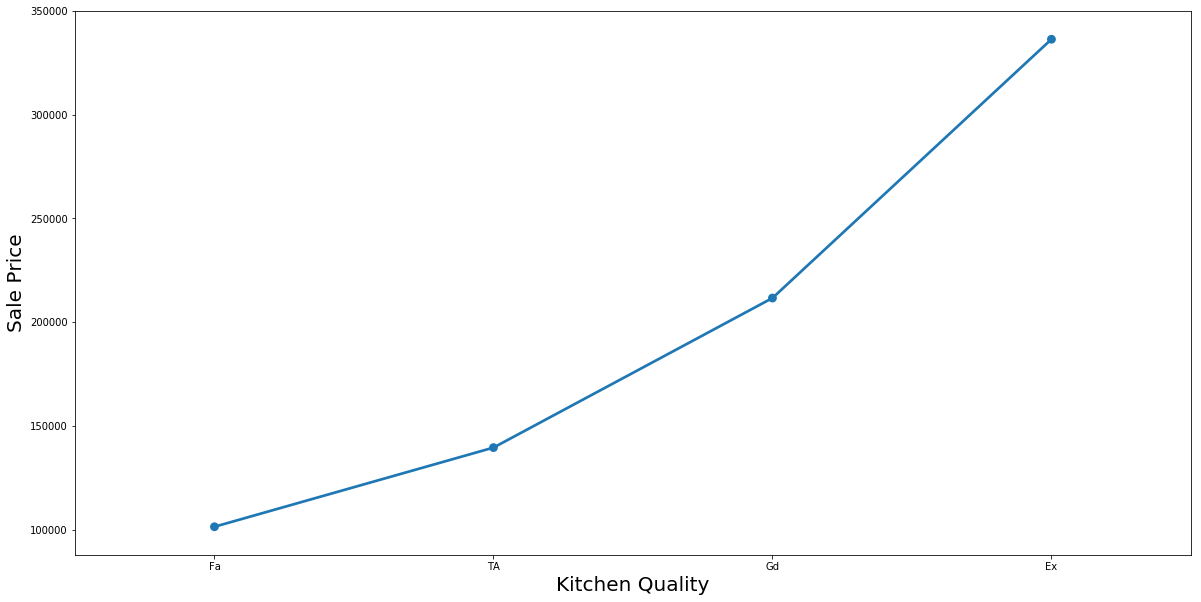

In [96]:
plt.figure(figsize=(20,10))
sns.pointplot(x = 'Kitchen Qual', y = 'SalePrice', data =df, 
              order = ['Fa', 'TA', 'Gd', 'Ex'], 
              orient = 'v', ci = 0)
plt.xlabel('Kitchen Quality',fontsize=20)
plt.ylabel('Sale Price',fontsize=20)

Text(0,0.5,'Sale Price')

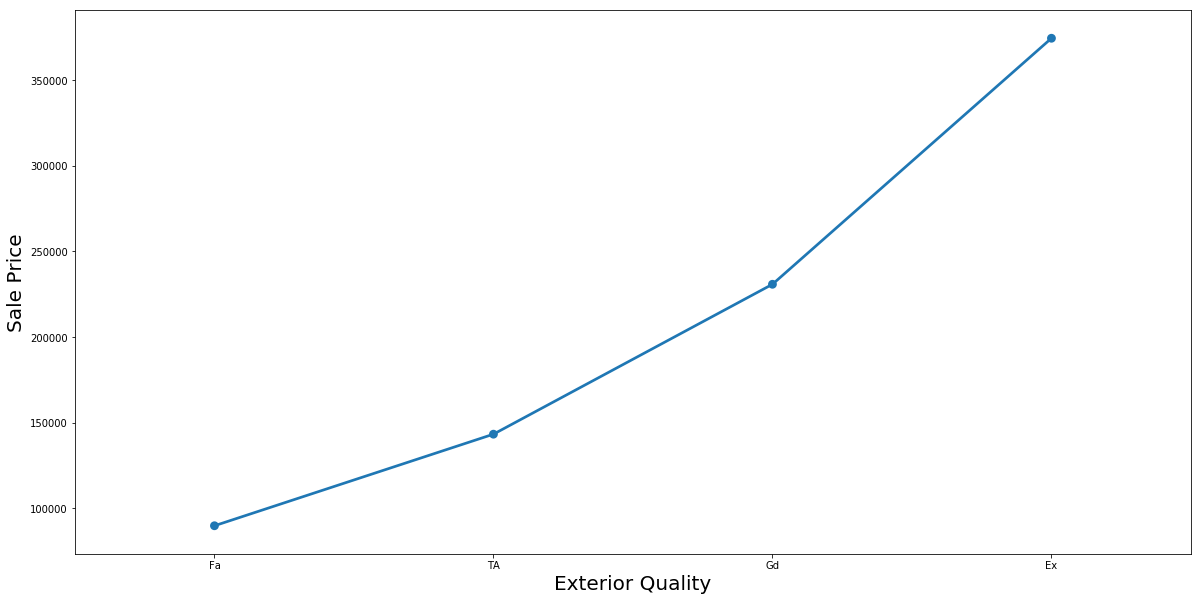

In [95]:
plt.figure(figsize=(20,10))
sns.pointplot(x = 'Exter Qual', y = 'SalePrice', data =df, 
              order = ['Fa', 'TA', 'Gd', 'Ex'], 
              orient = 'v', ci = 0)
plt.xlabel('Exterior Quality',fontsize=20)
plt.ylabel('Sale Price',fontsize=20)

Text(0,0.5,'Sale Price')

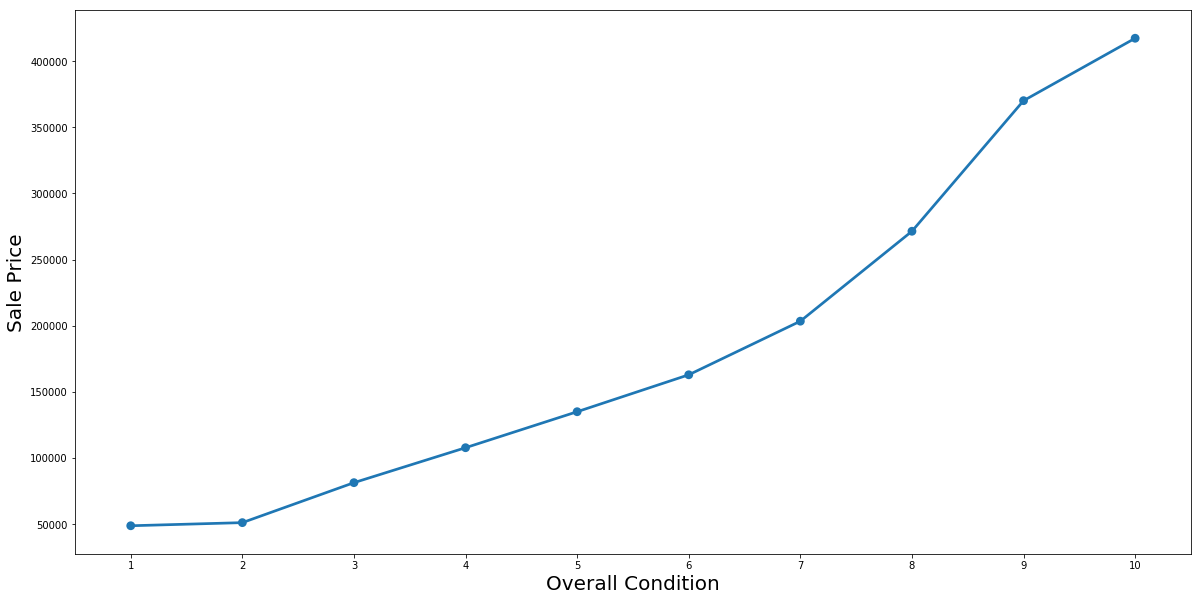

In [98]:
plt.figure(figsize=(20,10))
sns.pointplot(x = 'Overall Qual', y = 'SalePrice', data =df, 
              #order = ['TA', 'Fa', 'Gd', 'Ex'], 
              orient = 'v', ci = 0)
plt.xlabel('Overall Condition',fontsize=20)
plt.ylabel('Sale Price',fontsize=20)

Text(0,0.5,'Sale Price')

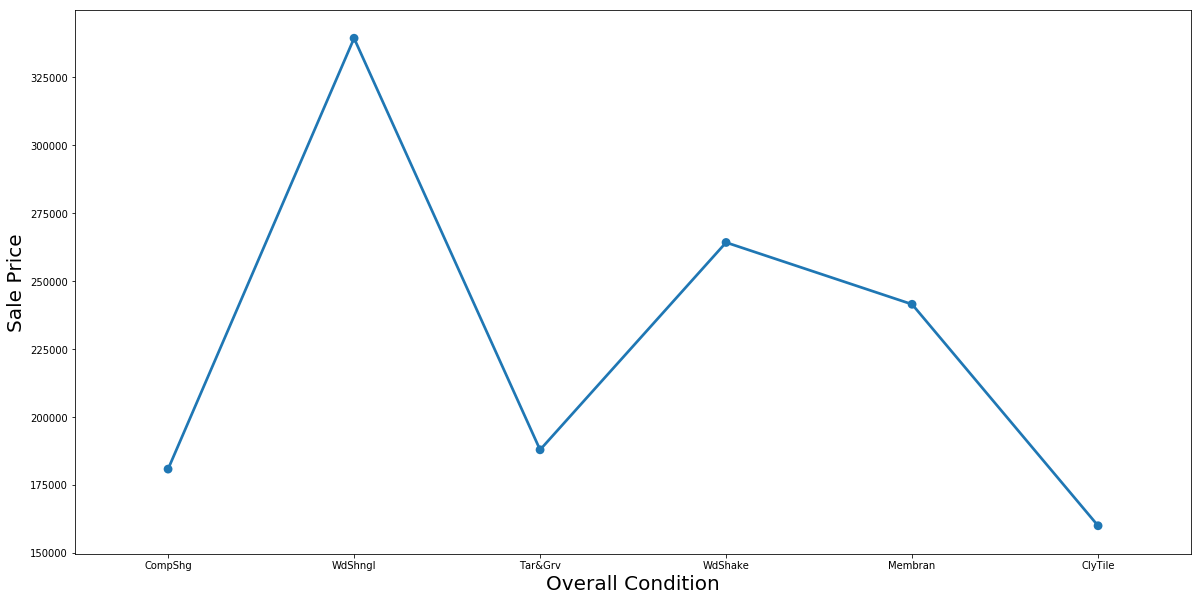

In [109]:
plt.figure(figsize=(20,10))
sns.pointplot(x = 'Roof Matl', y = 'SalePrice', data =df, 
              #order = ['TA', 'Fa', 'Gd', 'Ex'], 
              orient = 'v', ci = 0)
plt.xlabel('Overall Condition',fontsize=20)
plt.ylabel('Sale Price',fontsize=20)

# Saving my model for future use

In [13]:
with open('../assets/lasso.pkl', 'wb+') as f:
    pickle.dump(lasso, f)